# MyoPS 2020 Challenge

Ideas: 
 - load data via torchio
 - include meaningful augmentations
 - retrain base network (U-Net, resnet34)
 - use fastai2
 - use all labels (incl. LV, MY, RV)
 - use cross validation on training set to estimate performance

In [1]:
!pip install fastai2

In [2]:
!pip install git+https://github.com/Project-MONAI/MONAI#egg=MONAI

In [3]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34
from monai.losses import FocalLoss
import gc

### fastai U-Net on these static images

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = "/content/drive/My Drive/miccai2020/myops/png"

In [6]:
np.random.seed(42)
ids = np.arange(101,151)
np.random.shuffle(ids)
ids = np.reshape(ids,(-1,10))
ids

array([[114, 140, 131, 146, 118, 149, 127, 126, 133, 120],
       [113, 105, 138, 109, 104, 107, 142, 147, 148, 116],
       [110, 117, 125, 135, 132, 101, 145, 128, 134, 106],
       [130, 112, 137, 102, 122, 103, 144, 136, 124, 141],
       [111, 123, 119, 150, 121, 108, 143, 115, 129, 139]])

Use cropping instead of resizing

In [7]:
class AddMaskCodeMapping(Transform):
    "Add mapping of pixel value to class for a `TensorMask`"
    def __init__(self, mapping, codes=None):
        #print("init")
        self.mapping = mapping
        self.codes = codes
        if codes is not None: self.vocab,self.c = codes,len(codes)

    def encodes(self, o:PILMask):
        #print("encodes")
        mo = ToTensor()(o)
        mo = mo.to(dtype=torch.long)
        mo = self.mapping.index_select(0,mo.flatten()).reshape(*mo.shape)
        mo = PILMask.create(mo.to(dtype=torch.uint8))
        return mo
    
    def decodes(self, o:TensorMask):
        #print("decodes")
        if self.codes is not None: o._meta = {'codes': self.codes}
        return o

In [8]:
def MappedMaskBlock(mapping,codes=None):
    "A `TransformBlock` for segmentation masks, with mapping of pixel values to classes, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodeMapping(mapping=mapping,codes=codes), batch_tfms=IntToFloatTensor)

In [9]:
def getMappedMaskBlock(predefined_mapping_name):
  predefined_mappings = {
      'full': ([0,1,2,3,4,5],['bg','lv','my','rv','ed','sc']),
      'edOnly': ([0,0,0,0,1,0],['bg','ed']),
      'edScCombined': ([0,0,0,0,1,1],['bg','edSc']),
      'scOnly': ([0,0,0,0,0,1],['bg','sc'])
  }
  mapping,codes = predefined_mappings[predefined_mapping_name]
  return MappedMaskBlock(mapping = torch.LongTensor(mapping), codes=codes)

In [10]:
def getMyopsDls(val_ids, mapping_name="full", images="images"):
  mmb = getMappedMaskBlock(mapping_name)
  myopsData = DataBlock(blocks=(ImageBlock, mmb),#['bg','lv','my','rv','ed','sc'])),
      get_items=get_image_files,
      splitter=FuncSplitter(lambda o: int(o.name.split("-")[0]) in val_ids),
      get_y=lambda o: str(o).replace(images,"masks"),
      item_tfms=CropPad(256),
      batch_tfms=aug_transforms(max_rotate=90))
  return myopsData.dataloaders(f'{path}/{images}',num_workers=8,batch_size=12)

**Attention!** The cropped version can have masks close to the edge and zooming or rotation can lead to additional masks at the edge because of padding in reflection mode

In [11]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceFG(input, targs): return multi_dice(input,targs,class_id=1)

In [12]:
monaiFocal = FocalLoss(weight=torch.Tensor([.2,.8]),reduction='mean')
def myFocal(input, target):
  return monaiFocal(input, target.unsqueeze(1))

# EdOnly

In [13]:
learn = unet_learner(getMyopsDls(ids[2], "edOnly", "T2"), resnet34, loss_func=myFocal, metrics=[foreground_acc, diceFG])

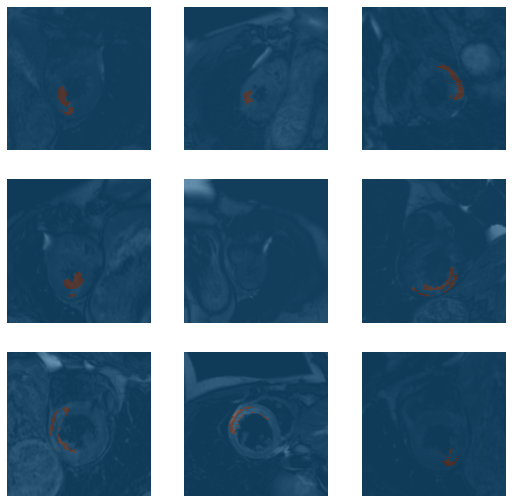

In [14]:
learn.dls.show_batch(vmin=0)

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=9.999999747378752e-06)

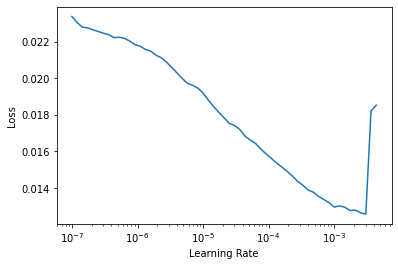

In [15]:
learn.lr_find()

In [16]:
learn.fine_tune(5, freeze_epochs=5, base_lr=1e-3)

epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.008139,0.005046,0.134270,0.137798,01:27
1,0.006394,0.004745,0.286633,0.200815,01:07
2,0.005469,0.005580,0.011596,0.161845,01:06
3,0.005181,0.004753,0.042653,0.137327,01:06
4,0.004668,0.003903,0.218677,0.264897,01:06


epoch,train_loss,valid_loss,foreground_acc,diceFG,time
0,0.003886,0.003927,0.209146,0.257970,01:09
1,0.003925,0.005227,0.384024,0.271554,01:09
2,0.003755,0.003874,0.322780,0.288219,01:09
3,0.003600,0.004133,0.417922,0.292295,01:08
4,0.003347,0.004236,0.335001,0.310210,01:09


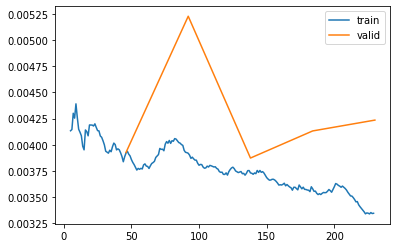

In [17]:
learn.recorder.plot_loss()

In [18]:
# does not work, needs proper decoding
# learn.show_results(vmin=0)

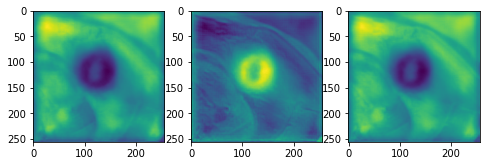

In [19]:
preds = learn.get_preds()
fig, axs = plt.subplots(1,3,figsize=(8,8))
axs[0].imshow(preds[0][1][0])
axs[1].imshow(preds[0][1][1])
axs[2].imshow(preds[0][1][0]-preds[0][1][1])

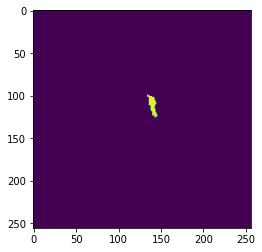

In [20]:
plt.imshow(preds[1][1])

In [21]:
learn.predi

DynamicUnet (Input shape: ['12 x 3 x 256 x 256'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               12 x 64 x 128 x 128  9,408      True      
________________________________________________________________
BatchNorm2d          12 x 64 x 128 x 128  128        True      
________________________________________________________________
ReLU                 12 x 64 x 128 x 128  0          False     
________________________________________________________________
MaxPool2d            12 x 64 x 64 x 64    0          False     
________________________________________________________________
Conv2d               12 x 64 x 64 x 64    36,864     True      
________________________________________________________________
BatchNorm2d          12 x 64 x 64 x 64    128        True      
________________________________________________________________
ReLU                 12 x 64 x 64 x 64    0          False     
________________________________________________

# Combine edema and scar